## Extract non-gridded data from gridded data

This notebook shows how to synthetically generate non-gridded data from gridded data.
**You will need the gridded data, which you can download with the `extract_anomalies.ipynb` notebook, before running this notebook.**

We'll simulate two general types of non-gridded data:
1) *Stations*, which will simply involve extracting N random points in the continuous lat-lon space covered by the grid and interpolating their values based on the surrounding gridded data, for the whole period of interest
2) *Buoys*, which will instead involve not only extracting N random points and their values, but also N nearest neighbours in subsequent time steps, adding jitter to simulate irregularity in the movement.

We'll use gridded mean sea level pressure anomalies (`msl` anomalies) as the starting point. 

### Stations

In [1]:
import xarray as xr
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from glob import glob
import os

The following iterates over all .nc files in a specified input folder, samples N random points (N can be changed as an argument when calling the function) from each of the files, and outputs a file with the same name under a specified output folder. The new .nc file will have:

- Coordinates: `time` and `station` (station index), plus each station's latitude and longitude.
- Data variables: `psl_anom_station`, a 2D array indexed by `(time, station)` that stores a value for every time–station pair.


In [2]:
def make_station_timeseries(input_folder, output_folder, n_stations=500, varname=None):
    files = sorted(glob(os.path.join(input_folder, "*.nc")))
    ds0 = xr.open_dataset(files[0], engine="h5netcdf")

    if (
        varname is None
    ):  # assumes single variable, if not then provide the variable name as argument
        varname = list(ds0.data_vars)[0]
    data0 = ds0[varname]

    lats = data0.latitude.values
    lons = data0.longitude.values
    flip_lat = False
    if (
        lats[0] > lats[-1]
    ):  # Latitudes should be ascending (required by RegularGridInterpolator), if not then flip
        lats = lats[::-1]
        flip_lat = True

    sampled_lats = np.random.uniform(lats.min(), lats.max(), n_stations)
    sampled_lons = np.random.uniform(lons.min(), lons.max(), n_stations)
    sample_coords = np.column_stack((sampled_lats, sampled_lons))

    os.makedirs(output_folder, exist_ok=True)

    for file in files:
        ds = xr.open_dataset(file, engine="h5netcdf")
        data = ds[varname]
        n_times = data.sizes["time"]
        values = np.empty((n_times, n_stations), dtype=np.float32)

        for t in range(n_times):
            slice_2d = data.isel(time=t)
            if flip_lat:
                slice_vals = slice_2d.values[
                    ::-1, :
                ]  # and flip the data if latitudes were flipped
            else:
                slice_vals = slice_2d.values
            interpolator = RegularGridInterpolator((lats, lons), slice_vals)
            values[t, :] = interpolator(sample_coords)

        station_ds = xr.Dataset(
            {
                f"{varname}_station": (
                    ("time", "station"),
                    values,
                )  # just append _station to the variable name and save time and station indexes
            },
            coords={
                "time": data.time.values,
                "station": np.arange(n_stations),
                "latitude": ("station", sampled_lats),
                "longitude": ("station", sampled_lons),
            },
        )
        filename = os.path.basename(file)
        outfile = os.path.join(output_folder, filename)
        station_ds.to_netcdf(outfile, engine="h5netcdf")

Run the above (NB: it assumes a single variable in the input file. If you need to process a specific variable, then specify it as an argument, e.g. `varname = 't2m'`)

In [5]:
make_station_timeseries(
    input_folder="../data/era5/anom_psl/south",
    n_stations=500,
    output_folder="../data/synthetic_non_gridded/anom_psl_stations/south",
)

Inspect one of the generated .nc files to ensure structure is as expected:

In [6]:
ds = xr.open_dataset(
    "../data/synthetic_non_gridded/anom_psl_stations/south/201401.nc", engine="h5netcdf"
)
print(ds)

<xarray.Dataset> Size: 74kB
Dimensions:           (time: 31, station: 500)
Coordinates:
  * time              (time) datetime64[ns] 248B 2014-01-01T12:00:00 ... 2014...
  * station           (station) int64 4kB 0 1 2 3 4 5 ... 495 496 497 498 499
    latitude          (station) float64 4kB ...
    longitude         (station) float64 4kB ...
Data variables:
    psl_anom_station  (time, station) float32 62kB ...


### Buoys

In [4]:
from scipy.spatial import cKDTree
import os
import numpy as np
import xarray as xr
from glob import glob
from scipy.interpolate import RegularGridInterpolator

In [5]:
def simulate_buoy_timeseries(
    input_folder, output_folder, n_buoys=100, step_deg=0.5, jitter_deg=0.2, varname=None
):
    os.makedirs(output_folder, exist_ok=True)
    nc_files = sorted(glob(os.path.join(input_folder, "*.nc")))

    for file in nc_files:
        ds = xr.open_dataset(file, engine="h5netcdf")

        if (
            varname is None
        ):  # same as above assumes single variable, if not then provide the variable name as argument
            varname = list(ds.data_vars)[0]

        data = ds[varname]
        lat_grid = ds.latitude.values
        lon_grid = ds.longitude.values

        if lat_grid.ndim == 1:
            lat_grid, lon_grid = np.meshgrid(lat_grid, lon_grid, indexing="ij")

        n_times = data.sizes["time"]
        grid_lat = lat_grid[:, 0]
        grid_lon = lon_grid[0, :]

        lat_min, lat_max = grid_lat.min(), grid_lat.max()
        lon_min, lon_max = grid_lon.min(), grid_lon.max()

        all_lat_tracks = []
        all_lon_tracks = []
        all_val_tracks = []

        for _ in range(n_buoys):
            lat = np.random.uniform(lat_min, lat_max)
            lon = np.random.uniform(lon_min, lon_max)
            angle = np.random.uniform(
                0, 2 * np.pi
            )  # pick a random direction around a cricle, 2pi is just the full circle

            lat_track, lon_track, val_track = (
                [],
                [],
                [],
            )  # first we store the whole trajectory of the buoy, then we'll format it into a dataset

            for t in range(n_times):
                slice_2d = data.isel(time=t).values
                interpolator = RegularGridInterpolator(
                    (grid_lat, grid_lon), slice_2d
                )  # just interpolate the data as we did with stations

                try:
                    val = interpolator([[lat, lon]])[0]
                except ValueError:
                    val = np.nan

                lat_track.append(lat)
                lon_track.append(lon)
                val_track.append(val)

                # Move the buoy
                angle += np.random.normal(
                    0, np.pi / 18
                )  # PI/18 is just 10 degree, so small random change in direction
                lat += step_deg * np.cos(angle) + np.random.normal(0, jitter_deg)
                lon += step_deg * np.sin(angle) + np.random.normal(0, jitter_deg)

                if not (lat_min <= lat <= lat_max and lon_min <= lon <= lon_max):
                    break  # out of bounds

            all_lat_tracks.append(lat_track)
            all_lon_tracks.append(lon_track)
            all_val_tracks.append(val_track)

        max_len = max(len(track) for track in all_lat_tracks)
        n_actual_buoys = len(all_lat_tracks)
        time = ds.time.values[:max_len]

        val_array = np.full((max_len, n_actual_buoys), np.nan)
        lat_array = np.full((max_len, n_actual_buoys), np.nan)
        lon_array = np.full((max_len, n_actual_buoys), np.nan)

        for i in range(n_actual_buoys):
            track_len = len(all_val_tracks[i])
            val_array[:track_len, i] = all_val_tracks[i]
            lat_array[:track_len, i] = all_lat_tracks[i]
            lon_array[:track_len, i] = all_lon_tracks[i]

        buoy_ds = xr.Dataset(
            {f"{varname}_buoy": (("time", "buoy"), val_array)},
            coords={
                "time": time,
                "buoy": np.arange(n_actual_buoys),
                "latitude": (("time", "buoy"), lat_array),
                "longitude": (("time", "buoy"), lon_array),
            },
        )

        filename = os.path.basename(file)
        out_path = os.path.join(output_folder, filename)
        buoy_ds.to_netcdf(out_path, engine="h5netcdf")

        print(f"Saved buoys to {out_path}")

Again, it assumes there is only one variable. If not, specify it as an argument (e.g. `varname='t2m'`). NB: this will take considerably longer than extracting stations.

In [ ]:
simulate_buoy_timeseries(
    input_folder="../data/era5/anom_psl/south/",
    output_folder="../data/synthetic_non_gridded/anom_psl_buoys/south/",
    n_buoys=100,
    step_deg=0.3,
    jitter_deg=0.2,
)

Inspect:

In [7]:
ds = xr.open_dataset(
    "../data/synthetic_non_gridded/anom_psl_buoys/south/201401.nc", engine="h5netcdf"
)
print(ds)

<xarray.Dataset> Size: 75kB
Dimensions:        (time: 31, buoy: 100)
Coordinates:
  * time           (time) datetime64[ns] 248B 2014-01-01T12:00:00 ... 2014-01...
  * buoy           (buoy) int64 800B 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
    latitude       (time, buoy) float64 25kB ...
    longitude      (time, buoy) float64 25kB ...
Data variables:
    psl_anom_buoy  (time, buoy) float64 25kB ...


### Plotting for sanity check

In [12]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation, PillowWriter
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from pathlib import Path
from IPython.display import Image, display

Let's plot some data as a sanity check. I'm focussing the map projection on a limited polar region (Arctic 60°N to 90°N, or Antarctic 60°S to 90°S), but the downloaded data generally spans the whole Southern or Northern emisphere (and so does the non-gridded data derived from it). Change the extent as needed for plotting.

In [ ]:
antarctic_extent = [-180, 180, -90, -60]
arctic_extent = [-180, 180, 60, 90]
folder = "../data/synthetic_non_gridded/anom_psl_stations/south"
start_date = "2019-12-01"  # Set to None to use numeric index instead
n_frames = 100

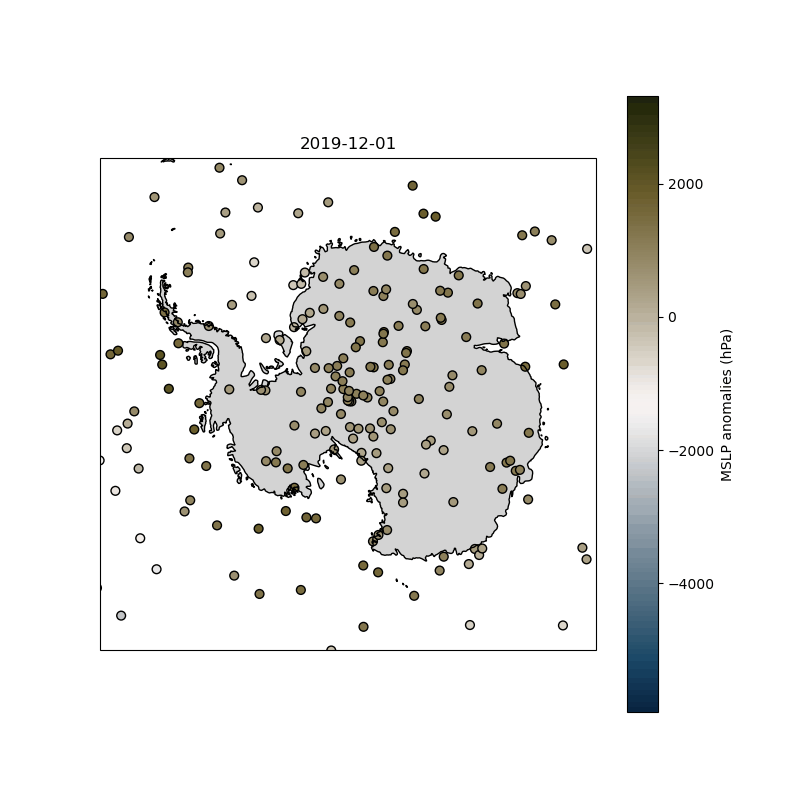

In [ ]:
files = sorted(glob(folder + "/*.nc"))
ds = xr.concat([xr.open_dataset(f, engine="h5netcdf") for f in files], dim="time")

if start_date:
    start = int(ds.time.values.searchsorted(np.datetime64(start_date)))
else:
    start = 0
end = min(start + n_frames, len(ds.time))

varname = list(ds.data_vars)[
    0
]  # again assumes single variable, if not then provide the variable name as argument
lats = ds.latitude.values
lons = ds.longitude.values
values_all = ds[varname].isel(time=slice(start, end)).values
vmin = np.nanmin(values_all)
vmax = np.nanmax(values_all)
norm = Normalize(vmin=vmin, vmax=vmax)

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent(antarctic_extent, crs=ccrs.PlateCarree())
ax.coastlines(linewidth=1)
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

sc = ax.scatter(
    lons,
    lats,
    c=values_all[0],
    cmap=cmocean.cm.diff,
    norm=norm,
    transform=ccrs.PlateCarree(),
    edgecolor="k",
    s=40,
)

cbar = fig.colorbar(
    ScalarMappable(norm=norm, cmap=cmocean.cm.diff),
    ax=ax,
    orientation="vertical",
    pad=0.05,
    label="MSLP anomalies (hPa)",
)

title = ax.set_title(str(ds.time[start].values)[:10])


def update(frame):
    sc.set_array(values_all[frame])
    title.set_text(str(ds.time[start + frame].values)[:10])
    return sc, title


ani = FuncAnimation(fig, update, frames=n_frames, interval=300)

gif_path = f"station_start_{start_date}.gif"
ani.save(gif_path, writer=PillowWriter(fps=3))
plt.close(fig)
Image(gif_path)

In [ ]:
def animate_buoy_dataset(
    ds_path, out_gif_path, varname="psl_anom_buoy", vmin=None, vmax=None, interval=200
):
    ds = xr.open_dataset(ds_path, engine="h5netcdf")
    time = ds.time.values
    n_frames = len(time)

    lat = ds.latitude  # shape: (time, buoy)
    lon = ds.longitude
    values = ds[varname]  # shape: (time, buoy)

    if vmin is None:
        vmin = np.nanmin(values.values)
    if vmax is None:
        vmax = np.nanmax(values.values)

    norm = plt.Normalize(vmin, vmax)

    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.set_extent(antarctic_extent, ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    sc = ax.scatter(
        [],
        [],
        c=[],
        cmap=cmocean.cm.diff,
        norm=norm,
        edgecolor="k",
        s=40,
        transform=ccrs.PlateCarree(),
    )

    title = ax.set_title("")

    def update(frame):
        lats = lat.isel(time=frame).values
        lons = lon.isel(time=frame).values
        vals = values.isel(time=frame).values

        sc.set_offsets(np.c_[lons, lats])
        sc.set_array(vals)
        title.set_text(str(time[frame])[:10])
        return sc, title

    anim = FuncAnimation(fig, update, frames=n_frames, interval=interval, blit=False)

    out_gif_path = Path(out_gif_path)
    if not out_gif_path.suffix.endswith(".gif"):
        out_gif_path = out_gif_path.with_suffix(".gif")
    out_gif_path.parent.mkdir(parents=True, exist_ok=True)

    anim.save(out_gif_path, writer=PillowWriter(fps=1000 // interval))
    plt.close(fig)  # avoid double output in notebook
    print(f"Saved animation to {out_gif_path}")

    display(Image(filename=str(out_gif_path)))

Saved animation to buoys_2014_05.gif


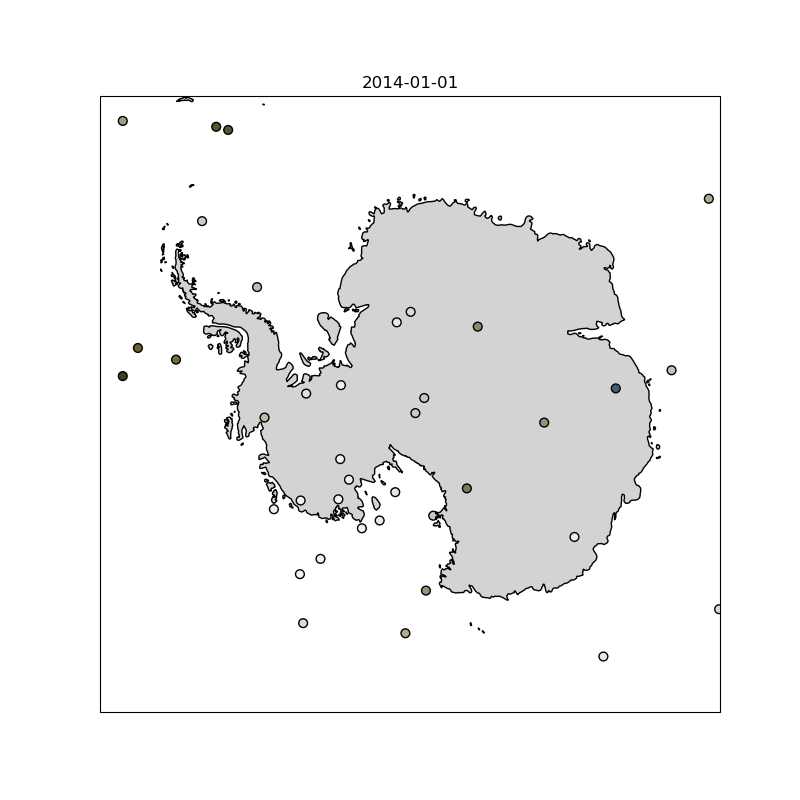

In [ ]:
animate_buoy_dataset(
    "../data/synthetic_non_gridded/anom_psl_buoys/south/201401.nc", "buoys_2014_05.gif"
)